# IBM Applied Data Science Capstone - Boyan Gu

## Recommendations on location and food type of a restaurant to open in New York

### 1 Introduction

#### 1.1 Background

New Tork is the most populous city in US, and is an international center of business, finance, arts, and culture. It is recognized as one of the most multicultural and cosmopolitan cities in the world. Its economy is highly diversified with strengths in technology, design, education, arts, tourism, and etc. Therefore, it will be of great chance to open a restaurant successfully and attractive customers, especially tourists.

#### 1.2 Business Problem

The target audiences of this project are investors who want to open a new restaurant targeting tourists. The problems for the investors now are where to open a restaurant is least competitive and can make a great profit, and which food types are popular and attractive for tourists in New York. We could simply assume that restaurants visited most are those locate near tourism-related venues (such as Arts & Entertainment, Nightlife, Outdoors & Recreation), which are convenient and attractive for tourists to get there. Therefore, we could locate tourism venues in New York, and do clustering to determine tourism cluster centers, where there are more tourists. Then we analyze the competition levels of restaurants around those centers, and determine the trending type of food that are favorable by visitors.

### 2 Data

This report would use data of tourism-related venues in New York region. New York json data would be scrapped from website, and Foursquare API would be used to get data of trending venues for analysis. 

#### 2.1 Data Preparation

Load libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import requests # library to handle requests
from sklearn.cluster import KMeans # import k-means from clustering stage
from sklearn.neighbors import KNeighborsClassifier
import urllib, json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Down load json data using url 

In [2]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json"
r = requests.get(url)
data = r.json()

In [3]:
neighborhoods_data = data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Transform data into a Pandas Dataframe

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Use geopy library to get the latitude and longitude values of New York City.

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Create a map of New York with neighborhoods superimposed on top.

In [9]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

For simplicity, we could focus on segment and cluster only the neighborhoods in Manhattan.

In [10]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [11]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [12]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

#### 2.2 Data Exploration of Neighborhoods in Manhattan

#### Foursquare API

Define Foursquare Credentials and Version

In [13]:
# @hidden_cell
CLIENT_ID = 'EYPKRBEE5K4B5TTNQHFGZEB00O0JFSVDXUQYL5XHNAY5JY53' # your Foursquare ID
CLIENT_SECRET = 'LVHDJGBCXSSINGQNGDT3QZHUOXAWM2RJ2JU4DMPIHJNIQRFR' # your Foursquare Secret
VERSION = '20210205' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Creare Foursqure API request URL and make the get request

In [14]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
            
# make the GET request
results = requests.get(url).json()

In [15]:
#results

check number of main categories and sub-categories present in Foursquare API

In [16]:
categories = len(results['response']['categories'])

for i in range(categories):
    venues = results['response']['categories'][i]['name']
    #print(venues)
    for j in range(len(results['response']['categories'][i]['categories'])):
        sub_venues = results['response']['categories'][i]['categories'][j]['name']
        #print('\t\t' + sub_venues)

In [17]:
all_categories = {}

for i in range(categories):
    venues = results['response']['categories'][i]['name']
    all_categories[venues] = i

print(all_categories)

{'Arts & Entertainment': 0, 'College & University': 1, 'Event': 2, 'Food': 3, 'Nightlife Spot': 4, 'Outdoors & Recreation': 5, 'Professional & Other Places': 6, 'Residence': 7, 'Shop & Service': 8, 'Travel & Transport': 9}


In [18]:
tourist_category = []
business_category = []
req_categories = ['Arts & Entertainment', 'Nightlife Spot', 'Outdoors & Recreation']
req_categories2 = ['Food', 'Shop & Service', 'Travel & Transport']


for i in req_categories:
    key = all_categories.get(i)
    venues = results['response']['categories'][key]['name']
    tourist_category.append(venues)
    for j in range(len(results['response']['categories'][key]['categories'])):
        sub_venues = results['response']['categories'][key]['categories'][j]['name']
        tourist_category.append(sub_venues)

for i in req_categories2:
    key = all_categories.get(i)
    venues = results['response']['categories'][key]['name']
    business_category.append(venues)
    for j in range(len(results['response']['categories'][key]['categories'])):
        sub_venues = results['response']['categories'][key]['categories'][j]['name']
        business_category.append(sub_venues)

In [19]:
#remove unwanted categories from tourist list
tourist_category.remove('Lounge')
tourist_category.remove('Movie Theater')
tourist_category.remove('Bar')
tourist_category.remove('Stables')
tourist_category.remove('Dog Run')
tourist_category.remove('Mini Golf')

#remove unwanted categories from business list
business_category.remove('Bus Station')
business_category.remove('ATM')
business_category.remove('Train Station')
business_category.remove('Bus Stop')
business_category.remove('Light Rail Station')
business_category.remove('Toll Booth')
business_category.remove('Toll Plaza')
business_category.remove('Tram Station')

Create a function to repeat the same process to all the neighborhoods in Manhattan to get nearby venues info

In [20]:
LIMIT = 100 # A default Foursquare API limit value
def getNearbyVenues_tourist(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    nearby_venues = nearby_venues[nearby_venues['Venue Category'].isin(tourist_category)]
    
    return(nearby_venues)

In [21]:
manhattan_venues = getNearbyVenues_tourist(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [22]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
36,Chinatown,40.715618,-73.994279,Museum at Eldridge Street,40.714724,-73.993497,Museum
47,Chinatown,40.715618,-73.994279,The Crown,40.715960,-73.996717,Roof Deck
49,Chinatown,40.715618,-73.994279,Chinatown Soup,40.715184,-73.991715,Historic Site
67,Chinatown,40.715618,-73.994279,Sofar HQ,40.713523,-73.996289,Music Venue
129,Washington Heights,40.851903,-73.936900,Highest Natural Point In Manhattan,40.852843,-73.937650,Park


In [23]:
manhattan_venues.shape

(230, 7)

In [24]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,19,19,19,19,19,19
Carnegie Hill,2,2,2,2,2,2
Central Harlem,5,5,5,5,5,5
Chelsea,11,11,11,11,11,11
Chinatown,4,4,4,4,4,4
Civic Center,8,8,8,8,8,8
Clinton,4,4,4,4,4,4
East Harlem,2,2,2,2,2,2
East Village,2,2,2,2,2,2


In [25]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))
manhattan_venues['Venue Category'].unique()

There are 33 uniques categories.


array(['Museum', 'Roof Deck', 'Historic Site', 'Music Venue', 'Park',
       'Pool', 'Scenic Lookout', 'Plaza', 'Playground', 'Trail',
       'Bike Trail', 'Art Gallery', 'Public Art', 'Exhibit', 'Bridge',
       'Athletics & Sports', 'Outdoors & Recreation', 'Waterfront',
       'Garden', 'Performing Arts Venue', 'Circus', 'Concert Hall',
       'Fountain', 'General Entertainment', 'Comedy Club',
       'Rock Climbing Spot', 'Other Great Outdoors', 'Nightclub', 'Hill',
       'Memorial Site', 'Pedestrian Plaza', 'Strip Club',
       'Harbor / Marina'], dtype=object)

In [26]:
venues_in_neiborhood = manhattan_venues.groupby('Neighborhood', as_index=False).count()
venues_in_neiborhood = venues_in_neiborhood[['Neighborhood','Venue']]
venues_in_neiborhood.rename(columns={'Venue':'Number of Venues'}, inplace=True)
venues_in_neiborhood['Number of Venues'].max()

20

<BarContainer object of 39 artists>

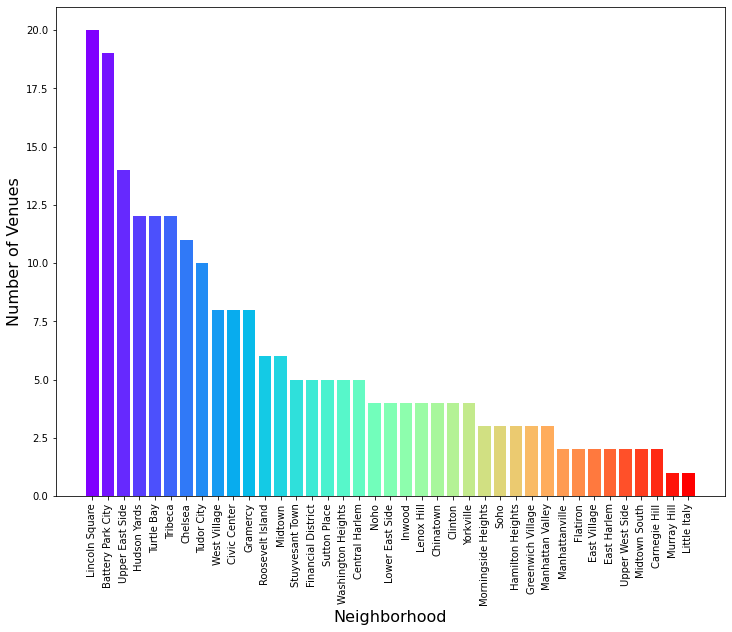

In [27]:
venues_in_neiborhood.sort_values('Number of Venues', ascending=False, inplace=True)
venues = venues_in_neiborhood['Number of Venues']
Neighborhood = venues_in_neiborhood['Neighborhood']

colors = cm.rainbow(np.linspace(0, 1, len(venues.index)))
plt.figure(figsize = (12, 9))
plt.xticks(rotation = 90)
plt.xlabel("Neighborhood", fontsize = 16)
plt.ylabel("Number of Venues", fontsize = 16)
plt.bar(Neighborhood, venues.values, color = colors)

#### Analyze each neighborhood

In [28]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Art Gallery,Athletics & Sports,Bike Trail,Bridge,Circus,Comedy Club,Concert Hall,Exhibit,Fountain,...,Playground,Plaza,Pool,Public Art,Rock Climbing Spot,Roof Deck,Scenic Lookout,Strip Club,Trail,Waterfront
36,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
49,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,Washington Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
manhattan_onehot.shape

(230, 34)

Group rows by venues and by taking the mean of the frequency of occurrence of each category

In [30]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
#manhattan_grouped

In [31]:
manhattan_grouped.shape

(39, 34)

Print each neighborhood along with the top 5 most common venues

In [32]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.42
1  Memorial Site  0.16
2          Plaza  0.11
3     Playground  0.11
4         Garden  0.05


----Carnegie Hill----
                   venue  freq
0                 Museum   0.5
1             Playground   0.5
2            Art Gallery   0.0
3                  Plaza   0.0
4  Outdoors & Recreation   0.0


----Central Harlem----
         venue  freq
0  Art Gallery   0.4
1         Park   0.2
2   Public Art   0.2
3  Music Venue   0.2
4       Circus   0.0


----Chelsea----
            venue  freq
0     Art Gallery  0.45
1       Nightclub  0.18
2            Park  0.18
3  Scenic Lookout  0.09
4           Plaza  0.09


----Chinatown----
           venue  freq
0    Music Venue  0.25
1         Museum  0.25
2  Historic Site  0.25
3      Roof Deck  0.25
4          Plaza  0.00


----Civic Center----
        venue  freq
0        Park  0.38
1  Playground  0.25
2      Museum  0.12
3  Strip Club  0.12
4   Nightclub  0.12


----Clinto

Put this into a pandas dataframe

In [33]:
#function to sort the business in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe and display the top 10 venues for each neighborhood.

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Memorial Site,Plaza,Playground,Scenic Lookout,Performing Arts Venue,Athletics & Sports,Garden,Bike Trail,Bridge
1,Carnegie Hill,Playground,Museum,Waterfront,Historic Site,Hill,Harbor / Marina,General Entertainment,Garden,Fountain,Exhibit
2,Central Harlem,Art Gallery,Public Art,Park,Music Venue,Roof Deck,Historic Site,Athletics & Sports,Bike Trail,Bridge,Circus
3,Chelsea,Art Gallery,Nightclub,Park,Scenic Lookout,Plaza,Exhibit,Harbor / Marina,General Entertainment,Garden,Fountain
4,Chinatown,Music Venue,Historic Site,Roof Deck,Museum,Fountain,Hill,Harbor / Marina,General Entertainment,Garden,Concert Hall


In [35]:
venue_venue_category = manhattan_venues.groupby(['Neighborhood', 'Venue Category'], as_index=False).agg(lambda x: ", ".join(x))
venue_venue_category.head()

,Neighborhood,Venue Category,Venue
0,Battery Park City,Athletics & Sports,Asphalt Green Battery Park City
1,Battery Park City,Garden,Liberty Community Garden
2,Battery Park City,Memorial Site,"9/11 Memorial North Pool, National September 1..."
3,Battery Park City,Park,"Battery Park City Esplanade, Hudson River Trai..."
4,Battery Park City,Performing Arts Venue,Winter Garden Atrium


In [36]:
r, c = neighborhoods_venues_sorted.shape

for rows in range(r):
    a = neighborhoods_venues_sorted.iloc[rows, 0]
    for col, col_name in enumerate(neighborhoods_venues_sorted.columns[1:]):
        b = neighborhoods_venues_sorted.iloc[rows, col+1]
        pf = venue_venue_category[venue_venue_category['Neighborhood'].str.contains(a) & venue_venue_category['Venue Category'].str.contains(b)]
        if not pf.empty:
            #print(b)
            idx = pf['Venue'].index.values.astype(int)[0]
            ven = pf['Venue'][idx]
            neighborhoods_venues_sorted.iloc[rows, neighborhoods_venues_sorted.columns.get_loc(col_name)] = ven
        elif pf.empty:
            neighborhoods_venues_sorted.iloc[rows, neighborhoods_venues_sorted.columns.get_loc(col_name)] = ''

Most common venues according to venue category in each neighbor

In [37]:
indicators = ['st', 'nd', 'rd']
new = []
for ind in np.arange(10):
    try:
        new.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        new.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted.columns = neighborhoods_venues_sorted.columns[:1].tolist() + new


In [38]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,"Battery Park City Esplanade, Hudson River Trai...","9/11 Memorial North Pool, National September 1...","Waterfront Plaza, Brookfield Place, Oculus Plaza","Kowsky Plaza Playground, West Thames Playground",One World Observatory,Winter Garden Atrium,Asphalt Green Battery Park City,Liberty Community Garden,,
1,Carnegie Hill,Samuel Seabury Playground,The Jewish Museum,,,,,,,,
2,Central Harlem,"La masion d'Art, Tatiana Pagès Gallery",Big L Memorial Mural,St. Nicholas Park,Shrine World Music Venue,,,,,,
3,Chelsea,"David Zwirner Gallery, Milk Gallery, Gagosian ...","PH-D at Dream Downtown, 1 OAK","High Line, Clement Clarke Moore Park",High Line 10th Ave Amphitheatre,London Terrace Gardens Courtyard,,,,,
4,Chinatown,Sofar HQ,Chinatown Soup,The Crown,Museum at Eldridge Street,,,,,,
5,Civic Center,"Foley Square, City Hall Park, Duane Park","Playgarden, Columbus Park Playground",FlashDancers Downtown,Mmuseumm,Paul's Cocktail Lounge,,,,,
6,Clinton,Rooftop 505 W.37th St.,MPHC Climbing Gym,UCB Theatre Hell’s Kitchen,Green Room 42,,,,,,
7,East Harlem,106 & Park Avenue,Pioneers' Gate,,,,,,,,
8,East Village,The Brant Foundation Art Study Center,Tompkins Square Park,,,,,,,,
9,Financial District,"Liberty Park, Bowling Green",9/11 Tribute Museum,Federal Hall National Memorial,Elevated Acre,,,,,,


#### Get Nearby Business

In [39]:
LIMIT = 500 # A default Foursquare API limit value

def getNearbyBusiness(names, latitudes, longitudes, radius=500):
    
    business_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby business
        business_list.append([(name,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_business = pd.DataFrame([item for business_list in business_list for item in business_list])
    nearby_business.columns = ['Neighborhood',
                    'Business', 
                    'BLatitude', 
                    'BLongitude', 
                    'Business Category']
    
    nearby_business = nearby_business[nearby_business['Business Category'].isin(business_category)]
    
    return(nearby_business)

In [40]:
nearby_business = getNearbyBusiness(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                   )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [41]:
print(nearby_business.shape)

(1779, 5)


In [42]:
nearby_business.head()

,Neighborhood,Business,BLatitude,BLongitude,Business Category
0,Marble Hill,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,Dunkin',40.877136,-73.906666,Donut Shop
5,Marble Hill,Starbucks,40.877531,-73.905582,Coffee Shop
7,Marble Hill,T.J. Maxx,40.877232,-73.905042,Department Store


In [43]:
num_nearby_business = nearby_business.groupby('Business Category', as_index=False).count()
num_nearby_business = num_nearby_business[['Business Category','Business']]
num_nearby_business.rename(columns={'Business':'No of Businesses'}, inplace=True)
num_nearby_business

,Business Category,No of Businesses
0,Adult Boutique,2
1,Afghan Restaurant,1
2,African Restaurant,3
3,American Restaurant,86
4,Antique Shop,1
...,...,...
141,Used Bookstore,1
142,Vegetarian / Vegan Restaurant,18
143,Video Game Store,3
144,Video Store,1


In [44]:
print('There are {} uniques categories.'.format(len(nearby_business['Business Category'].unique())))

There are 146 uniques categories.


In [45]:
# one hot encoding
nearby_business_onehot = pd.get_dummies(nearby_business[['Business Category']], prefix="", prefix_sep="")

# add venue column back to dataframe
nearby_business_onehot['Neighborhood'] = nearby_business['Neighborhood'] 

# move venue column to the first column
fixed_columns = [nearby_business_onehot.columns[-1]] + list(nearby_business_onehot.columns[:-1])
nearby_business_onehot = nearby_business_onehot[fixed_columns]

nearby_business_onehot.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Austrian Restaurant,...,Tea Room,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Wings Joint
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
nearby_business_onehot.shape

(1779, 147)

In [47]:
nearby_business_grouped = nearby_business_onehot.groupby('Neighborhood').mean().reset_index()
nearby_business_grouped

,Neighborhood,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Austrian Restaurant,...,Tea Room,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Wings Joint
0,Battery Park City,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,Carnegie Hill,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.00,0.000000
2,Central Harlem,0.000000,0.000000,0.130435,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,Chelsea,0.000000,0.000000,0.000000,0.078431,0.000000,0.000000,0.019608,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Chinatown,0.000000,0.000000,0.000000,0.078431,0.000000,0.000000,0.039216,0.000000,0.019608,...,0.019608,0.00,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.00,0.000000
5,Civic Center,0.000000,0.000000,0.000000,0.075472,0.018868,0.000000,0.018868,0.018868,0.000000,...,0.000000,0.00,0.000000,0.018868,0.000000,0.000000,0.018868,0.000000,0.00,0.000000
6,Clinton,0.000000,0.000000,0.000000,0.088889,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
7,East Harlem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
8,East Village,0.000000,0.000000,0.000000,0.040816,0.000000,0.020408,0.000000,0.000000,0.000000,...,0.020408,0.00,0.000000,0.000000,0.000000,0.020408,0.061224,0.000000,0.00,0.000000
9,Financial District,0.000000,0.000000,0.000000,0.081967,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


In [48]:
nearby_business_grouped.shape

(40, 147)

In [49]:
num_top_business = 5

for hood in nearby_business_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nearby_business_grouped[nearby_business_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Neighborhood','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_business))
    print('\n')

----Battery Park City----
     Neighborhood  freq
0  Clothing Store  0.11
1     Coffee Shop  0.11
2           Hotel  0.08
3     Pizza Place  0.05
4       BBQ Joint  0.05


----Carnegie Hill----
        Neighborhood  freq
0        Coffee Shop  0.14
1               Café  0.12
2  French Restaurant  0.06
3          Bookstore  0.06
4     Cosmetics Shop  0.06


----Central Harlem----
          Neighborhood  freq
0   African Restaurant  0.13
1  American Restaurant  0.09
2       Cosmetics Shop  0.09
3   Seafood Restaurant  0.09
4    French Restaurant  0.09


----Chelsea----
          Neighborhood  freq
0          Coffee Shop  0.14
1   Italian Restaurant  0.08
2               Bakery  0.08
3  American Restaurant  0.08
4    French Restaurant  0.08


----Chinatown----
          Neighborhood  freq
0               Bakery  0.14
1  American Restaurant  0.08
2                  Spa  0.06
3   Salon / Barbershop  0.06
4         Dessert Shop  0.06


----Civic Center----
          Neighborhood  freq
0      

In [50]:
#function to sort the business in descending order
def return_most_common_business(row, num_top_business):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_business]

In [51]:
num_top_business = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top business
columns = ['Neighborhood']
for ind in np.arange(num_top_business):
    try:
        columns.append('{}{} Most Common Business'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Business'.format(ind+1))

# create a new dataframe
nearby_business_sorted = pd.DataFrame(columns=columns)
nearby_business_sorted['Neighborhood'] = nearby_business_grouped['Neighborhood']

for ind in np.arange(nearby_business_grouped.shape[0]):
    nearby_business_sorted.iloc[ind, 1:] = return_most_common_business(nearby_business_grouped.iloc[ind, :], num_top_business)

venues_in_neiborhood = manhattan_venues.groupby('Neighborhood', as_index=False).count()
venues_in_neiborhood = venues_in_neiborhood[['Neighborhood','Venue']]
venues_in_neiborhood.rename(columns={'Venue':'Number of Venues'}, inplace=True)
venues_in_neiborhood['Number of Venues'].max()
nearby_business_sorted

,Neighborhood,1st Most Common Business,2nd Most Common Business,3rd Most Common Business,4th Most Common Business,5th Most Common Business,6th Most Common Business,7th Most Common Business,8th Most Common Business,9th Most Common Business,10th Most Common Business
0,Battery Park City,Coffee Shop,Clothing Store,Hotel,Food Court,BBQ Joint,Italian Restaurant,Sandwich Place,Burger Joint,Pizza Place,Shopping Mall
1,Carnegie Hill,Coffee Shop,Café,Cosmetics Shop,Pizza Place,Bookstore,French Restaurant,Italian Restaurant,Bakery,Shipping Store,American Restaurant
2,Central Harlem,African Restaurant,French Restaurant,Cosmetics Shop,American Restaurant,Seafood Restaurant,BBQ Joint,Southern / Soul Food Restaurant,Spa,Juice Bar,Caribbean Restaurant
3,Chelsea,Coffee Shop,French Restaurant,American Restaurant,Italian Restaurant,Bakery,Hotel,Bookstore,Seafood Restaurant,Pet Store,Market
4,Chinatown,Bakery,American Restaurant,Salon / Barbershop,Dessert Shop,Spa,Mexican Restaurant,Asian Restaurant,Bubble Tea Shop,Dumpling Restaurant,Optical Shop
5,Civic Center,Coffee Shop,Spa,American Restaurant,French Restaurant,Hotel,Falafel Restaurant,Bakery,Italian Restaurant,Burger Joint,Bookstore
6,Clinton,Italian Restaurant,American Restaurant,Coffee Shop,Hotel,Sandwich Place,Spa,French Restaurant,Juice Bar,Pizza Place,Mediterranean Restaurant
7,East Harlem,Mexican Restaurant,Bakery,Latin American Restaurant,Sandwich Place,Deli / Bodega,Café,Spa,Spanish Restaurant,Restaurant,Steakhouse
8,East Village,Mexican Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Italian Restaurant,Bagel Shop,Salon / Barbershop,American Restaurant,Dessert Shop,Coffee Shop,Seafood Restaurant
9,Financial District,Coffee Shop,American Restaurant,Pizza Place,Salad Place,Italian Restaurant,Steakhouse,Mediterranean Restaurant,Sandwich Place,Jewelry Store,Hotel


In [52]:
number_nearby_business = nearby_business.groupby('Neighborhood', as_index=False).count()
number_nearby_business = number_nearby_business[['Neighborhood','Business']]
number_nearby_business.rename(columns={'Business':'Number of Businesses'}, inplace=True)
number_nearby_business

,Neighborhood,Number of Businesses
0,Battery Park City,38
1,Carnegie Hill,51
2,Central Harlem,23
3,Chelsea,51
4,Chinatown,51
5,Civic Center,53
6,Clinton,45
7,East Harlem,23
8,East Village,49
9,Financial District,61


In [53]:
print('There are {} uniques categories.'.format(len(nearby_business['Business Category'].unique())))

There are 146 uniques categories.


In [54]:
number_nearby_business['Number of Businesses'].max()

69

<BarContainer object of 40 artists>

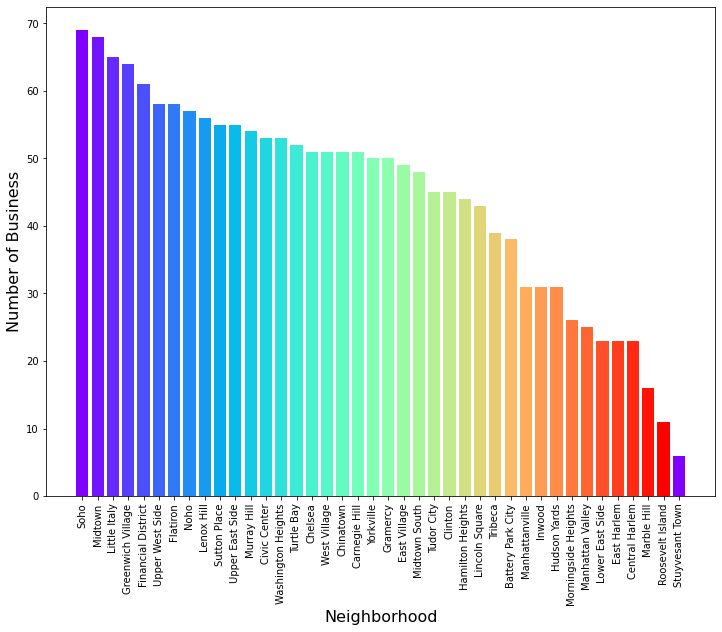

In [55]:
number_nearby_business.sort_values('Number of Businesses', ascending=False, inplace=True)
business = number_nearby_business['Number of Businesses']
Neighborhood = number_nearby_business['Neighborhood']

colors = cm.rainbow(np.linspace(0, 1, len(venues.index)))
plt.figure(figsize = (12, 9))
plt.xticks(rotation = 90)
plt.xlabel("Neighborhood", fontsize = 16)
plt.ylabel("Number of Business", fontsize = 16)
plt.bar(Neighborhood, business.values, color = colors)

#### 2.3 Perform Clustering

Find the optimal k value for clustering of tourism venues

In [56]:
from sklearn import metrics

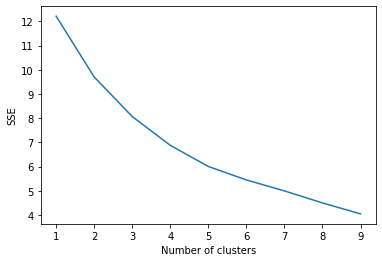

In [57]:
sse = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(manhattan_grouped.drop('Neighborhood',axis=1))
    manhattan_grouped['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

Find the optimal k value for clustering of tourist-related business

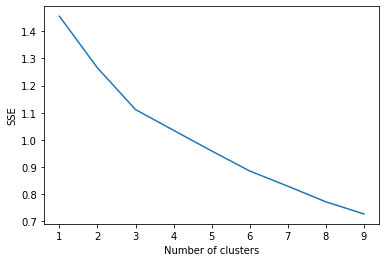

In [58]:
sse2 = {}
for k in range(1,10):
    kmeans2 = KMeans(n_clusters=k,random_state=0)
    kmeans2.fit(nearby_business_grouped.drop('Neighborhood',axis=1))
    nearby_business_grouped['Cluster'] = kmeans2.labels_
    sse2[k] = kmeans2.inertia_

plt.figure()
plt.plot(list(sse2.keys()), list(sse2.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

Use the optimal k value obtained from the above graph for clustering

#### a. Clustering for tourism venues

In [59]:
# set number of clusters
kclusters = 3

manhattan_tourism_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_tourism_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 2, 2, 2, 0, 2, 0, 1, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [60]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Manhattan,Chinatown,40.715618,-73.994279,2.0,Sofar HQ,Chinatown Soup,The Crown,Museum at Eldridge Street,,,,,,
2,Manhattan,Washington Heights,40.851903,-73.936900,0.0,"Highest Natural Point In Manhattan, Bennett Park",Chittenden Overlook,Highbridge Park Pool,Dominican Square,,,,,,
3,Manhattan,Inwood,40.867684,-73.921210,0.0,"Isham Park, Inwood Hill Park",Indian Road Playground,Stairing Is Caring,,,,,,,
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0.0,"Riverside Park 138th St Entrance, Montefiore Park",Hamilton Grange National Memorial,,,,,,,,


In [61]:
manhattan_merged = manhattan_merged.dropna(how = 'any')
manhattan_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Manhattan,Chinatown,40.715618,-73.994279,2.0,Sofar HQ,Chinatown Soup,The Crown,Museum at Eldridge Street,,,,,,
2,Manhattan,Washington Heights,40.851903,-73.936900,0.0,"Highest Natural Point In Manhattan, Bennett Park",Chittenden Overlook,Highbridge Park Pool,Dominican Square,,,,,,
3,Manhattan,Inwood,40.867684,-73.921210,0.0,"Isham Park, Inwood Hill Park",Indian Road Playground,Stairing Is Caring,,,,,,,
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0.0,"Riverside Park 138th St Entrance, Montefiore Park",Hamilton Grange National Memorial,,,,,,,,
5,Manhattan,Manhattanville,40.816934,-73.957385,0.0,Hudson River Greenway Bike Path,West Harlem Piers Park,,,,,,,,
6,Manhattan,Central Harlem,40.815976,-73.943211,2.0,"La masion d'Art, Tatiana Pagès Gallery",Big L Memorial Mural,St. Nicholas Park,Shrine World Music Venue,,,,,,
7,Manhattan,East Harlem,40.792249,-73.944182,0.0,106 & Park Avenue,Pioneers' Gate,,,,,,,,
8,Manhattan,Upper East Side,40.775639,-73.960508,2.0,"Greek and Roman Art, The Great Hall, Arts of A...","Ukrainian Institute of America, Gagosian Galle...",Glade Arch,Metropolitan Museum Steps,James Michael Levin Playground,Iris & B Gerald Cantor Roof Garden,,,,
9,Manhattan,Yorkville,40.775930,-73.947118,0.0,"Carl Schurz Park, East River Promenade",Yorkville Tennis Club,Asphalt Green Aquacenter,,,,,,,
10,Manhattan,Lenox Hill,40.768113,-73.958860,2.0,"Bohemian National Hall, Sotheby's","The Playroom NYC, St. Catherine's Park",,,,,,,,


In [62]:
manhattan_merged['Cluster Labels'] = manhattan_merged['Cluster Labels'].astype(int)

Visualize resulting clusters

In [63]:
import matplotlib
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#print(colors_array)
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]
#print(rainbow)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters of Tourism Venues

Examine each cluster and determine the venues that distinguish each cluster.

##### Cluster 1

In [64]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,"Highest Natural Point In Manhattan, Bennett Park",Chittenden Overlook,Highbridge Park Pool,Dominican Square,,,,,,
3,Inwood,"Isham Park, Inwood Hill Park",Indian Road Playground,Stairing Is Caring,,,,,,,
4,Hamilton Heights,"Riverside Park 138th St Entrance, Montefiore Park",Hamilton Grange National Memorial,,,,,,,,
5,Manhattanville,Hudson River Greenway Bike Path,West Harlem Piers Park,,,,,,,,
7,East Harlem,106 & Park Avenue,Pioneers' Gate,,,,,,,,
9,Yorkville,"Carl Schurz Park, East River Promenade",Yorkville Tennis Club,Asphalt Green Aquacenter,,,,,,,
11,Roosevelt Island,"Manhattan Park, Michelle's Bench",East Side River Walk,Eleanor's Pier,71st Street Pedestrian Bridge,Roosevelt Island Promenade,,,,,
18,Greenwich Village,Center for Architecture,Mercer Playground,Comedy Cellar,,,,,,,
21,Tribeca,"Pier 26 - Hudson River Park, Pier 25 - Hudson ...","Pier 25 Playground, Washington Market Park","West Side Promenade, Pier 34",Tribeca Performing Arts Center,Muse Paintbar,Arlo Rooftop Bar,,,,
24,West Village,"Bleecker Street Park, Hudson River Park Run, H...",Stephen Weiss Studio,Hudson River Greenway Running Path,The Garden at St. Luke in the Fields,HB Studio,,,,,


##### Cluster 2

In [65]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Upper West Side,Children's Museum of Manhattan (CMOM),West Side Community Garden,,,,,,,,
16,Murray Hill,The Morgan Library & Museum,,,,,,,,,
19,East Village,The Brant Foundation Art Study Center,Tompkins Square Park,,,,,,,,
22,Little Italy,Elizabeth Street Garden,,,,,,,,,
23,Soho,"Eden Fine Art, Leslie+Lohman Museum of Gay & L...",,,,,,,,,
30,Carnegie Hill,Samuel Seabury Playground,The Jewish Museum,,,,,,,,
31,Noho,"Richard Taittinger Gallery, Sperone Westwater,...",,,,,,,,,
38,Flatiron,Fotografiska,Madison Square Park,,,,,,,,


##### Cluster 3

In [66]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Sofar HQ,Chinatown Soup,The Crown,Museum at Eldridge Street,,,,,,
6,Central Harlem,"La masion d'Art, Tatiana Pagès Gallery",Big L Memorial Mural,St. Nicholas Park,Shrine World Music Venue,,,,,,
8,Upper East Side,"Greek and Roman Art, The Great Hall, Arts of A...","Ukrainian Institute of America, Gagosian Galle...",Glade Arch,Metropolitan Museum Steps,James Michael Levin Playground,Iris & B Gerald Cantor Roof Garden,,,,
10,Lenox Hill,"Bohemian National Hall, Sotheby's","The Playroom NYC, St. Catherine's Park",,,,,,,,
13,Lincoln Square,"Josie Robertson Plaza (Lincoln Center Plaza), ...","American Ballet Theatre, Lincoln Center Out of...","New York Philharmonic, David Geffen Hall, Alic...",Seventieth Street Playground (aka PS 199 Playg...,Gertrude Ederle Recreation Center,The Empire Hotel Rooftop,SAG-AFTRA,Big Apple Circus,Lincoln Center’s Revson Fountain,West End Towers Park
14,Clinton,Rooftop 505 W.37th St.,MPHC Climbing Gym,UCB Theatre Hell’s Kitchen,Green Room 42,,,,,,
15,Midtown,The Lionel Pincus and Princess Firyal Map Divi...,The Town Hall,Library Walk,Bryant Park,New York Public Library Terrace,Harvard Club of New York City,,,,
17,Chelsea,"David Zwirner Gallery, Milk Gallery, Gagosian ...","PH-D at Dream Downtown, 1 OAK","High Line, Clement Clarke Moore Park",High Line 10th Ave Amphitheatre,London Terrace Gardens Courtyard,,,,,
20,Lower East Side,"Spoke Art NYC, Abrons Arts Center",Hillman Park,Caveat,,,,,,,
33,Midtown South,86th Floor Observation Deck,Simple Studios,,,,,,,,


##### b. Clustering for tourist-related business 

In [67]:
# set number of clusters
kclusters2 = 3

manhattan_business_clustering = nearby_business_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_business_clustering)

# check cluster labels generated for each row in the dataframe
kmeans2.labels_[0:10]

array([0, 0, 2, 0, 0, 0, 0, 2, 0, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 businesses for each neighborhood.

In [68]:
# add clustering labels
nearby_business_sorted.insert(0, 'Cluster Labels', kmeans2.labels_)

business_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
business_merged = business_merged.join(nearby_business_sorted.set_index('Neighborhood'), on='Neighborhood')

business_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Business,2nd Most Common Business,3rd Most Common Business,4th Most Common Business,5th Most Common Business,6th Most Common Business,7th Most Common Business,8th Most Common Business,9th Most Common Business,10th Most Common Business
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Coffee Shop,Sandwich Place,Deli / Bodega,Donut Shop,Discount Store,Diner,Steakhouse,Supplement Shop,Pizza Place,Department Store
1,Manhattan,Chinatown,40.715618,-73.994279,0,Bakery,American Restaurant,Salon / Barbershop,Dessert Shop,Spa,Mexican Restaurant,Asian Restaurant,Bubble Tea Shop,Dumpling Restaurant,Optical Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Café,Bakery,Bank,Mobile Phone Shop,Sandwich Place,Spanish Restaurant,Deli / Bodega,Latin American Restaurant,Supplement Shop,Donut Shop
3,Manhattan,Inwood,40.867684,-73.921210,2,Mexican Restaurant,Restaurant,Café,Bakery,Deli / Bodega,Caribbean Restaurant,Diner,Pizza Place,Fast Food Restaurant,Seafood Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Pizza Place,Café,Coffee Shop,Mexican Restaurant,Deli / Bodega,Sandwich Place,Indian Restaurant,Latin American Restaurant,Caribbean Restaurant,Bakery


In [69]:
import matplotlib
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#print(colors_array)
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]
#print(rainbow)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(business_merged['Latitude'], business_merged['Longitude'], business_merged['Neighborhood'], business_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters of Tourist-related Businesses

#### Cluster 1

In [70]:
business_merged.loc[business_merged['Cluster Labels'] == 0, business_merged.columns[[1] + list(range(5, business_merged.shape[1]))]]

,Neighborhood,1st Most Common Business,2nd Most Common Business,3rd Most Common Business,4th Most Common Business,5th Most Common Business,6th Most Common Business,7th Most Common Business,8th Most Common Business,9th Most Common Business,10th Most Common Business
1,Chinatown,Bakery,American Restaurant,Salon / Barbershop,Dessert Shop,Spa,Mexican Restaurant,Asian Restaurant,Bubble Tea Shop,Dumpling Restaurant,Optical Shop
8,Upper East Side,Italian Restaurant,Coffee Shop,Bakery,French Restaurant,Pizza Place,Juice Bar,American Restaurant,Hotel,Spa,Salad Place
10,Lenox Hill,Italian Restaurant,Pizza Place,Coffee Shop,Café,Burger Joint,Deli / Bodega,Sporting Goods Shop,Salon / Barbershop,Salad Place,Czech Restaurant
12,Upper West Side,Italian Restaurant,Bakery,Mediterranean Restaurant,Café,Coffee Shop,Pizza Place,American Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Breakfast Spot
13,Lincoln Square,Café,Bakery,American Restaurant,Clothing Store,Italian Restaurant,Cosmetics Shop,Mexican Restaurant,Furniture / Home Store,Coffee Shop,French Restaurant
14,Clinton,Italian Restaurant,American Restaurant,Coffee Shop,Hotel,Sandwich Place,Spa,French Restaurant,Juice Bar,Pizza Place,Mediterranean Restaurant
15,Midtown,Hotel,Coffee Shop,Clothing Store,Sporting Goods Shop,American Restaurant,Bookstore,Sandwich Place,Bakery,Steakhouse,Indian Restaurant
16,Murray Hill,Coffee Shop,Hotel,Sandwich Place,American Restaurant,Burger Joint,Pizza Place,Health & Beauty Service,Vegetarian / Vegan Restaurant,Bakery,Jewish Restaurant
17,Chelsea,Coffee Shop,French Restaurant,American Restaurant,Italian Restaurant,Bakery,Hotel,Bookstore,Seafood Restaurant,Pet Store,Market
19,East Village,Mexican Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Italian Restaurant,Bagel Shop,Salon / Barbershop,American Restaurant,Dessert Shop,Coffee Shop,Seafood Restaurant


##### Cluster 2

In [71]:
business_merged.loc[business_merged['Cluster Labels'] == 1, business_merged.columns[[1] + list(range(5, business_merged.shape[1]))]]

,Neighborhood,1st Most Common Business,2nd Most Common Business,3rd Most Common Business,4th Most Common Business,5th Most Common Business,6th Most Common Business,7th Most Common Business,8th Most Common Business,9th Most Common Business,10th Most Common Business
0,Marble Hill,Coffee Shop,Sandwich Place,Deli / Bodega,Donut Shop,Discount Store,Diner,Steakhouse,Supplement Shop,Pizza Place,Department Store
9,Yorkville,Italian Restaurant,Coffee Shop,Deli / Bodega,Mexican Restaurant,Diner,Bagel Shop,Spa,Sandwich Place,Bank,Café
11,Roosevelt Island,Greek Restaurant,Pizza Place,Dry Cleaner,Bubble Tea Shop,Sandwich Place,Metro Station,Food & Drink Shop,Cosmetics Shop,Deli / Bodega,American Restaurant
18,Greenwich Village,Italian Restaurant,Clothing Store,Indian Restaurant,Coffee Shop,American Restaurant,Café,Dessert Shop,Caribbean Restaurant,Cosmetics Shop,Bakery
23,Soho,Clothing Store,Italian Restaurant,Bakery,Coffee Shop,Mediterranean Restaurant,Sporting Goods Shop,Salon / Barbershop,Asian Restaurant,Dessert Shop,Optical Shop
24,West Village,Italian Restaurant,American Restaurant,Cosmetics Shop,Coffee Shop,Pizza Place,Bakery,Gastropub,French Restaurant,Falafel Restaurant,Latin American Restaurant
37,Stuyvesant Town,Coffee Shop,Gas Station,Boat or Ferry,Bistro,Heliport,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner


#### Cluster 3

In [72]:
business_merged.loc[business_merged['Cluster Labels'] == 2, business_merged.columns[[1] + list(range(5, business_merged.shape[1]))]]

,Neighborhood,1st Most Common Business,2nd Most Common Business,3rd Most Common Business,4th Most Common Business,5th Most Common Business,6th Most Common Business,7th Most Common Business,8th Most Common Business,9th Most Common Business,10th Most Common Business
2,Washington Heights,Café,Bakery,Bank,Mobile Phone Shop,Sandwich Place,Spanish Restaurant,Deli / Bodega,Latin American Restaurant,Supplement Shop,Donut Shop
3,Inwood,Mexican Restaurant,Restaurant,Café,Bakery,Deli / Bodega,Caribbean Restaurant,Diner,Pizza Place,Fast Food Restaurant,Seafood Restaurant
4,Hamilton Heights,Pizza Place,Café,Coffee Shop,Mexican Restaurant,Deli / Bodega,Sandwich Place,Indian Restaurant,Latin American Restaurant,Caribbean Restaurant,Bakery
5,Manhattanville,Coffee Shop,Deli / Bodega,Seafood Restaurant,Mexican Restaurant,Italian Restaurant,Food & Drink Shop,Café,Dumpling Restaurant,Latin American Restaurant,Falafel Restaurant
6,Central Harlem,African Restaurant,French Restaurant,Cosmetics Shop,American Restaurant,Seafood Restaurant,BBQ Joint,Southern / Soul Food Restaurant,Spa,Juice Bar,Caribbean Restaurant
7,East Harlem,Mexican Restaurant,Bakery,Latin American Restaurant,Sandwich Place,Deli / Bodega,Café,Spa,Spanish Restaurant,Restaurant,Steakhouse
20,Lower East Side,Latin American Restaurant,Bakery,Coffee Shop,Pizza Place,Café,Deli / Bodega,Clothing Store,Pharmacy,Caribbean Restaurant,Diner
25,Manhattan Valley,Coffee Shop,Mexican Restaurant,Indian Restaurant,Pizza Place,Wings Joint,Bubble Tea Shop,Hawaiian Restaurant,Furniture / Home Store,French Restaurant,Italian Restaurant
26,Morningside Heights,Coffee Shop,Bookstore,American Restaurant,Burger Joint,Café,Mexican Restaurant,Sandwich Place,Salad Place,Mediterranean Restaurant,Pizza Place
35,Turtle Bay,Coffee Shop,Hotel,Seafood Restaurant,Deli / Bodega,Café,Indian Restaurant,Italian Restaurant,Greek Restaurant,Steakhouse,Pharmacy
